# Method 9 - Best Minus Rest Top 3

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)
                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] <= 3].copy()                                                                    
short_ideas = valid_data[valid_data['pos_rank'] > 3].copy()

# Weight the best ideas

long_ideas['target'] = long_ideas['target'] / long_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / long_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

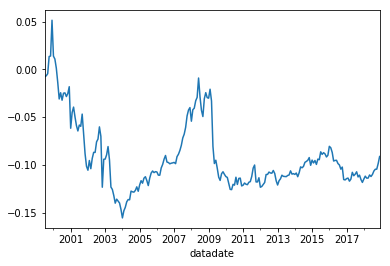

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.051431
2000-12-31   -0.066183
2001-12-31   -0.084849
2002-12-31    0.008171
2003-12-31   -0.058023
2004-12-31    0.022347
2005-12-31    0.023534
2006-12-31    0.010280
2007-12-31    0.064195
2008-12-31    0.010833
2009-12-31   -0.082765
2010-12-31   -0.013624
2011-12-31    0.009768
2012-12-31   -0.003528
2013-12-31    0.008391
2014-12-31    0.009829
2015-12-31    0.011713
2016-12-31   -0.028428
2017-12-31   -0.002914
2018-12-31    0.030744
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     44.75
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.80e-28
Time:                        21:07:39   Log-Likelihood:                 808.94
No. Observations:                 234   AIC:                            -1608.
Df Residuals:                     229   BIC:                            -1591.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -1.400      0.163      -0.002       0.000
mktrf         -0.0169      0.014     -1.175      0.241      -0.045       0.011
me            -0.0060      0.017     -0.359      0.720      -0.039       0.027
ia            -0.1501      0.025     -5.902      0.000      -0.200      -0.100
roe            0.2124      0.022      9.758      0.000       0.169       0.255
==============================================================================
Omnibus:                       49.294   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              413.285
Skew:                          -0.488   Prob(JB):                     1.80e-90
Kurtosis:                       9.437   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     12.39
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.89e-09
Time:                        21:07:39   Log-Likelihood:                 808.94
No. Observations:                 234   AIC:                            -1608.
Df Residuals:                     229   BIC:                            -1591.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -1.257      0.209      -0.002       0.000
mktrf         -0.0169      0.017     -1.013      0.311      -0.050       0.016
me            -0.0060      0.027     -0.225      0.822      -0.058       0.046
ia            -0.1501      0.063     -2.392      0.017      -0.273      -0.027
roe            0.2124      0.042      5.031      0.000       0.130       0.295
==============================================================================
Omnibus:                       49.294   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              413.285
Skew:                          -0.488   Prob(JB):                     1.80e-90
Kurtosis:                       9.437   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     11.69
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.18e-08
Time:                        21:07:39   Log-Likelihood:                 808.94
No. Observations:                 234   AIC:                            -1608.
Df Residuals:                     229   BIC:                            -1591.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -1.070      0.285      -0.002       0.001
mktrf         -0.0169      0.016     -1.030      0.303      -0.049       0.015
me            -0.0060      0.029     -0.207      0.836      -0.063       0.051
ia            -0.1501      0.058     -2.601      0.009      -0.263      -0.037
roe            0.2124      0.044      4.804      0.000       0.126       0.299
==============================================================================
Omnibus:                       49.294   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              413.285
Skew:                          -0.488   Prob(JB):                     1.80e-90
Kurtosis:                       9.437   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     18.16
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.68e-15
Time:                        21:07:39   Log-Likelihood:                 780.60
No. Observations:                 234   AIC:                            -1549.
Df Residuals:                     228   BIC:                            -1528.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.345      0.730      -0.001       0.001
mktrf         -0.0517      0.016     -3.172      0.002      -0.084      -0.020
smb           -0.0259      0.022     -1.206      0.229      -0.068       0.016
hml           -0.0823      0.025     -3.244      0.001      -0.132      -0.032
rmw            0.1218      0.029      4.247      0.000       0.065       0.178
cma           -0.0593      0.036     -1.626      0.105      -0.131       0.013
==============================================================================
Omnibus:                       83.910   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              693.469
Skew:                          -1.148   Prob(JB):                    2.60e-151
Kurtosis:                      11.115   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     19.77
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.36e-16
Time:                        21:07:39   Log-Likelihood:                 780.60
No. Observations:                 234   AIC:                            -1549.
Df Residuals:                     228   BIC:                            -1528.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.337      0.736      -0.001       0.001
mktrf         -0.0517      0.016     -3.224      0.001      -0.083      -0.020
smb           -0.0259      0.036     -0.713      0.476      -0.097       0.045
hml           -0.0823      0.035     -2.378      0.017      -0.150      -0.014
rmw            0.1218      0.049      2.461      0.014       0.025       0.219
cma           -0.0593      0.094     -0.634      0.526      -0.243       0.124
==============================================================================
Omnibus:                       83.910   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              693.469
Skew:                          -1.148   Prob(JB):                    2.60e-151
Kurtosis:                      11.115   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     20.83
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.96e-17
Time:                        21:07:39   Log-Likelihood:                 780.60
No. Observations:                 234   AIC:                            -1549.
Df Residuals:                     228   BIC:                            -1528.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.289      0.773      -0.002       0.001
mktrf         -0.0517      0.015     -3.411      0.001      -0.081      -0.022
smb           -0.0259      0.033     -0.776      0.438      -0.092       0.040
hml           -0.0823      0.035     -2.328      0.020      -0.152      -0.013
rmw            0.1218      0.053      2.313      0.021       0.019       0.225
cma           -0.0593      0.095     -0.621      0.534      -0.246       0.128
==============================================================================
Omnibus:                       83.910   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              693.469
Skew:                          -1.148   Prob(JB):                    2.60e-151
Kurtosis:                      11.115   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     127.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.90e-57
Time:                        21:07:39   Log-Likelihood:                 878.57
No. Observations:                 234   AIC:                            -1747.
Df Residuals:                     229   BIC:                            -1730.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.000     -1.657      0.099      -0.001       0.000
mktrf         -0.0007      0.010     -0.073      0.942      -0.020       0.019
smb           -0.1221      0.012     -9.950      0.000      -0.146      -0.098
hml           -0.0440      0.012     -3.609      0.000      -0.068      -0.020
umd            0.1494      0.008     18.678      0.000       0.134       0.165
==============================================================================
Omnibus:                       67.943   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              502.745
Skew:                          -0.898   Prob(JB):                    6.77e-110
Kurtosis:                       9.953   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     37.39
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.67e-24
Time:                        21:07:39   Log-Likelihood:                 878.57
No. Observations:                 234   AIC:                            -1747.
Df Residuals:                     229   BIC:                            -1730.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.000     -1.335      0.182      -0.002       0.000
mktrf         -0.0007      0.015     -0.049      0.961      -0.030       0.028
smb           -0.1221      0.012    -10.174      0.000      -0.146      -0.099
hml           -0.0440      0.013     -3.335      0.001      -0.070      -0.018
umd            0.1494      0.017      8.877      0.000       0.116       0.182
==============================================================================
Omnibus:                       67.943   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              502.745
Skew:                          -0.898   Prob(JB):                    6.77e-110
Kurtosis:                       9.953   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     29.86
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.40e-20
Time:                        21:07:39   Log-Likelihood:                 878.57
No. Observations:                 234   AIC:                            -1747.
Df Residuals:                     229   BIC:                            -1730.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -1.138      0.255      -0.002       0.000
mktrf         -0.0007      0.016     -0.045      0.964      -0.032       0.031
smb           -0.1221      0.012     -9.819      0.000      -0.147      -0.098
hml           -0.0440      0.013     -3.471      0.001      -0.069      -0.019
umd            0.1494      0.018      8.453      0.000       0.115       0.184
==============================================================================
Omnibus:                       67.943   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              502.745
Skew:                          -0.898   Prob(JB):                    6.77e-110
Kurtosis:                       9.953   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     29.88
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.85e-17
Time:                        21:07:39   Log-Likelihood:                 391.10
No. Observations:                 120   AIC:                            -772.2
Df Residuals:                     115   BIC:                            -758.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.001     -1.931      0.056      -0.004    4.53e-05
mktrf          0.0098      0.024      0.399      0.690      -0.039       0.058
me             0.0288      0.024      1.191      0.236      -0.019       0.077
ia            -0.1956      0.038     -5.168      0.000      -0.271      -0.121
roe            0.2877      0.034      8.584      0.000       0.221       0.354
==============================================================================
Omnibus:                       17.015   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.999
Skew:                          -0.156   Prob(JB):                     6.31e-16
Kurtosis:                       6.729   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     20.10
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.42e-12
Time:                        21:07:39   Log-Likelihood:                 391.10
No. Observations:                 120   AIC:                            -772.2
Df Residuals:                     115   BIC:                            -758.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.001     -1.781      0.075      -0.004       0.000
mktrf          0.0098      0.022      0.452      0.652      -0.033       0.052
me             0.0288      0.031      0.939      0.348      -0.031       0.089
ia            -0.1956      0.078     -2.512      0.012      -0.348      -0.043
roe            0.2877      0.042      6.879      0.000       0.206       0.370
==============================================================================
Omnibus:                       17.015   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.999
Skew:                          -0.156   Prob(JB):                     6.31e-16
Kurtosis:                       6.729   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     21.52
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.84e-13
Time:                        21:07:39   Log-Likelihood:                 391.10
No. Observations:                 120   AIC:                            -772.2
Df Residuals:                     115   BIC:                            -758.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.001     -1.526      0.127      -0.004       0.000
mktrf          0.0098      0.019      0.518      0.604      -0.027       0.047
me             0.0288      0.034      0.850      0.395      -0.038       0.095
ia            -0.1956      0.073     -2.692      0.007      -0.338      -0.053
roe            0.2877      0.039      7.424      0.000       0.212       0.364
==============================================================================
Omnibus:                       17.015   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.999
Skew:                          -0.156   Prob(JB):                     6.31e-16
Kurtosis:                       6.729   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     8.687
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.28e-07
Time:                        21:07:39   Log-Likelihood:                 367.71
No. Observations:                 120   AIC:                            -723.4
Df Residuals:                     114   BIC:                            -706.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.001     -0.996      0.322      -0.003       0.001
mktrf         -0.0590      0.032     -1.874      0.064      -0.121       0.003
smb            0.0028      0.036      0.078      0.938      -0.068       0.073
hml           -0.1039      0.044     -2.376      0.019      -0.191      -0.017
rmw            0.1619      0.052      3.140      0.002       0.060       0.264
cma           -0.0794      0.056     -1.405      0.163      -0.191       0.033
==============================================================================
Omnibus:                       27.532   Durbin-Watson:                   2.254
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.517
Skew:                          -0.776   Prob(JB):                     1.21e-18
Kurtosis:                       6.754   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     10.43
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.96e-08
Time:                        21:07:39   Log-Likelihood:                 367.71
No. Observations:                 120   AIC:                            -723.4
Df Residuals:                     114   BIC:                            -706.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.001     -0.932      0.351      -0.004       0.001
mktrf         -0.0590      0.031     -1.878      0.060      -0.121       0.003
smb            0.0028      0.051      0.054      0.957      -0.097       0.103
hml           -0.1039      0.047     -2.196      0.028      -0.197      -0.011
rmw            0.1619      0.065      2.495      0.013       0.035       0.289
cma           -0.0794      0.113     -0.705      0.481      -0.300       0.141
==============================================================================
Omnibus:                       27.532   Durbin-Watson:                   2.254
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.517
Skew:                          -0.776   Prob(JB):                     1.21e-18
Kurtosis:                       6.754   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     12.51
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.11e-09
Time:                        21:07:39   Log-Likelihood:                 367.71
No. Observations:                 120   AIC:                            -723.4
Df Residuals:                     114   BIC:                            -706.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.001     -0.791      0.429      -0.004       0.002
mktrf         -0.0590      0.030     -1.958      0.050      -0.118    5.12e-05
smb            0.0028      0.045      0.062      0.951      -0.086       0.091
hml           -0.1039      0.045     -2.286      0.022      -0.193      -0.015
rmw            0.1619      0.064      2.547      0.011       0.037       0.286
cma           -0.0794      0.115     -0.692      0.489      -0.304       0.145
==============================================================================
Omnibus:                       27.532   Durbin-Watson:                   2.254
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.517
Skew:                          -0.776   Prob(JB):                     1.21e-18
Kurtosis:                       6.754   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     83.31
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.66e-33
Time:                        21:07:39   Log-Likelihood:                 429.96
No. Observations:                 120   AIC:                            -849.9
Df Residuals:                     115   BIC:                            -836.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -1.375      0.172      -0.002       0.000
mktrf          0.0177      0.016      1.132      0.260      -0.013       0.049
smb           -0.1420      0.018     -7.998      0.000      -0.177      -0.107
hml           -0.0524      0.018     -2.948      0.004      -0.088      -0.017
umd            0.1724      0.011     15.718      0.000       0.151       0.194
==============================================================================
Omnibus:                       27.154   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.232
Skew:                          -0.725   Prob(JB):                     4.20e-20
Kurtosis:                       6.968   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     30.78
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.06e-17
Time:                        21:07:39   Log-Likelihood:                 429.96
No. Observations:                 120   AIC:                            -849.9
Df Residuals:                     115   BIC:                            -836.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -1.115      0.265      -0.002       0.001
mktrf          0.0177      0.017      1.047      0.295      -0.015       0.051
smb           -0.1420      0.015     -9.755      0.000      -0.171      -0.114
hml           -0.0524      0.014     -3.680      0.000      -0.080      -0.025
umd            0.1724      0.018      9.652      0.000       0.137       0.207
==============================================================================
Omnibus:                       27.154   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.232
Skew:                          -0.725   Prob(JB):                     4.20e-20
Kurtosis:                       6.968   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     32.69
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.42e-18
Time:                        21:07:39   Log-Likelihood:                 429.96
No. Observations:                 120   AIC:                            -849.9
Df Residuals:                     115   BIC:                            -836.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -0.950      0.342      -0.003       0.001
mktrf          0.0177      0.017      1.051      0.293      -0.015       0.051
smb           -0.1420      0.014     -9.872      0.000      -0.170      -0.114
hml           -0.0524      0.014     -3.790      0.000      -0.080      -0.025
umd            0.1724      0.017     10.083      0.000       0.139       0.206
==============================================================================
Omnibus:                       27.154   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.232
Skew:                          -0.725   Prob(JB):                     4.20e-20
Kurtosis:                       6.968   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     28.05
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.06e-16
Time:                        21:07:39   Log-Likelihood:                 478.39
No. Observations:                 114   AIC:                            -946.8
Df Residuals:                     109   BIC:                            -933.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.941      0.349      -0.000       0.001
mktrf         -0.0311      0.011     -2.839      0.005      -0.053      -0.009
me            -0.0880      0.017     -5.206      0.000      -0.122      -0.055
ia            -0.0721      0.023     -3.074      0.003      -0.119      -0.026
roe            0.0584      0.021      2.835      0.005       0.018       0.099
==============================================================================
Omnibus:                        3.987   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.136   Jarque-Bera (JB):                3.808
Skew:                          -0.249   Prob(JB):                        0.149
Kurtosis:                       3.744   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     51.86
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.18e-24
Time:                        21:07:39   Log-Likelihood:                 478.39
No. Observations:                 114   AIC:                            -946.8
Df Residuals:                     109   BIC:                            -933.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.021      0.307      -0.000       0.001
mktrf         -0.0311      0.013     -2.340      0.019      -0.057      -0.005
me            -0.0880      0.018     -4.961      0.000      -0.123      -0.053
ia            -0.0721      0.030     -2.397      0.017      -0.131      -0.013
roe            0.0584      0.024      2.464      0.014       0.012       0.105
==============================================================================
Omnibus:                        3.987   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.136   Jarque-Bera (JB):                3.808
Skew:                          -0.249   Prob(JB):                        0.149
Kurtosis:                       3.744   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     66.68
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.04e-28
Time:                        21:07:39   Log-Likelihood:                 478.39
No. Observations:                 114   AIC:                            -946.8
Df Residuals:                     109   BIC:                            -933.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.892      0.372      -0.000       0.001
mktrf         -0.0311      0.014     -2.193      0.028      -0.059      -0.003
me            -0.0880      0.017     -5.307      0.000      -0.121      -0.056
ia            -0.0721      0.034     -2.139      0.032      -0.138      -0.006
roe            0.0584      0.024      2.480      0.013       0.012       0.105
==============================================================================
Omnibus:                        3.987   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.136   Jarque-Bera (JB):                3.808
Skew:                          -0.249   Prob(JB):                        0.149
Kurtosis:                       3.744   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     26.92
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.37e-17
Time:                        21:07:39   Log-Likelihood:                 484.17
No. Observations:                 114   AIC:                            -956.3
Df Residuals:                     108   BIC:                            -939.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.045      0.298      -0.000       0.001
mktrf         -0.0336      0.010     -3.371      0.001      -0.053      -0.014
smb           -0.0809      0.016     -4.996      0.000      -0.113      -0.049
hml           -0.0736      0.021     -3.565      0.001      -0.115      -0.033
rmw            0.0383      0.025      1.516      0.133      -0.012       0.088
cma           -0.0083      0.032     -0.257      0.797      -0.072       0.055
==============================================================================
Omnibus:                        3.909   Durbin-Watson:                   2.246
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                3.387
Skew:                          -0.312   Prob(JB):                        0.184
Kurtosis:                       3.568   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     122.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.66e-43
Time:                        21:07:39   Log-Likelihood:                 484.17
No. Observations:                 114   AIC:                            -956.3
Df Residuals:                     108   BIC:                            -939.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.440      0.150      -0.000       0.001
mktrf         -0.0336      0.011     -3.023      0.003      -0.055      -0.012
smb           -0.0809      0.012     -6.799      0.000      -0.104      -0.058
hml           -0.0736      0.017     -4.440      0.000      -0.106      -0.041
rmw            0.0383      0.021      1.857      0.063      -0.002       0.079
cma           -0.0083      0.031     -0.267      0.790      -0.069       0.052
==============================================================================
Omnibus:                        3.909   Durbin-Watson:                   2.246
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                3.387
Skew:                          -0.312   Prob(JB):                        0.184
Kurtosis:                       3.568   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     200.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.59e-53
Time:                        21:07:39   Log-Likelihood:                 484.17
No. Observations:                 114   AIC:                            -956.3
Df Residuals:                     108   BIC:                            -939.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.380      0.168      -0.000       0.001
mktrf         -0.0336      0.012     -2.818      0.005      -0.057      -0.010
smb           -0.0809      0.012     -7.026      0.000      -0.103      -0.058
hml           -0.0736      0.016     -4.681      0.000      -0.104      -0.043
rmw            0.0383      0.019      1.986      0.047       0.001       0.076
cma           -0.0083      0.034     -0.246      0.806      -0.074       0.058
==============================================================================
Omnibus:                        3.909   Durbin-Watson:                   2.246
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                3.387
Skew:                          -0.312   Prob(JB):                        0.184
Kurtosis:                       3.568   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     50.83
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.43e-24
Time:                        21:07:39   Log-Likelihood:                 498.05
No. Observations:                 114   AIC:                            -986.1
Df Residuals:                     109   BIC:                            -972.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.625      0.534      -0.000       0.001
mktrf         -0.0282      0.009     -3.224      0.002      -0.045      -0.011
smb           -0.0932      0.014     -6.847      0.000      -0.120      -0.066
hml           -0.0585      0.014     -4.172      0.000      -0.086      -0.031
umd            0.0622      0.011      5.882      0.000       0.041       0.083
==============================================================================
Omnibus:                        1.980   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.372   Jarque-Bera (JB):                1.530
Skew:                          -0.269   Prob(JB):                        0.465
Kurtosis:                       3.181   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     81.02
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.27e-32
Time:                        21:07:39   Log-Likelihood:                 498.05
No. Observations:                 114   AIC:                            -986.1
Df Residuals:                     109   BIC:                            -972.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.067      0.286      -0.000       0.001
mktrf         -0.0282      0.009     -3.186      0.001      -0.045      -0.011
smb           -0.0932      0.013     -7.105      0.000      -0.119      -0.068
hml           -0.0585      0.013     -4.494      0.000      -0.084      -0.033
umd            0.0622      0.011      5.789      0.000       0.041       0.083
==============================================================================
Omnibus:                        1.980   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.372   Jarque-Bera (JB):                1.530
Skew:                          -0.269   Prob(JB):                        0.465
Kurtosis:                       3.181   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     81.39
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.71e-32
Time:                        21:07:39   Log-Likelihood:                 498.05
No. Observations:                 114   AIC:                            -986.1
Df Residuals:                     109   BIC:                            -972.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.064      0.287      -0.000       0.001
mktrf         -0.0282      0.010     -2.884      0.004      -0.047      -0.009
smb           -0.0932      0.013     -7.105      0.000      -0.119      -0.068
hml           -0.0585      0.014     -4.150      0.000      -0.086      -0.031
umd            0.0622      0.012      5.235      0.000       0.039       0.086
==============================================================================
Omnibus:                        1.980   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.372   Jarque-Bera (JB):                1.530
Skew:                          -0.269   Prob(JB):                        0.465
Kurtosis:                       3.181   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""